Time taken to create sequences: 0.06 seconds
Batch time: 2.56 seconds
Batch time: 1.29 seconds
Batch time: 1.13 seconds
Batch time: 1.40 seconds
Batch time: 0.97 seconds
Batch time: 1.04 seconds
Batch time: 1.02 seconds
Batch time: 1.05 seconds
Batch time: 1.13 seconds
Batch time: 1.16 seconds
Batch time: 1.16 seconds
Batch time: 1.16 seconds
Batch time: 1.18 seconds
Batch time: 1.32 seconds
Batch time: 28.42 seconds
Batch time: 0.85 seconds
Batch time: 0.72 seconds
Batch time: 0.64 seconds
Batch time: 0.64 seconds
Batch time: 0.66 seconds
Batch time: 0.63 seconds
Batch time: 0.66 seconds
Batch time: 0.71 seconds
Batch time: 0.77 seconds
Batch time: 0.82 seconds
Batch time: 0.78 seconds
Batch time: 0.66 seconds
Batch time: 0.74 seconds
Batch time: 1.13 seconds
Batch time: 0.80 seconds
Batch time: 0.71 seconds
Batch time: 0.71 seconds
Batch time: 0.69 seconds
Batch time: 0.68 seconds
Batch time: 0.66 seconds
Batch time: 0.64 seconds
Batch time: 0.60 seconds
Batch time: 0.64 seconds
Batc

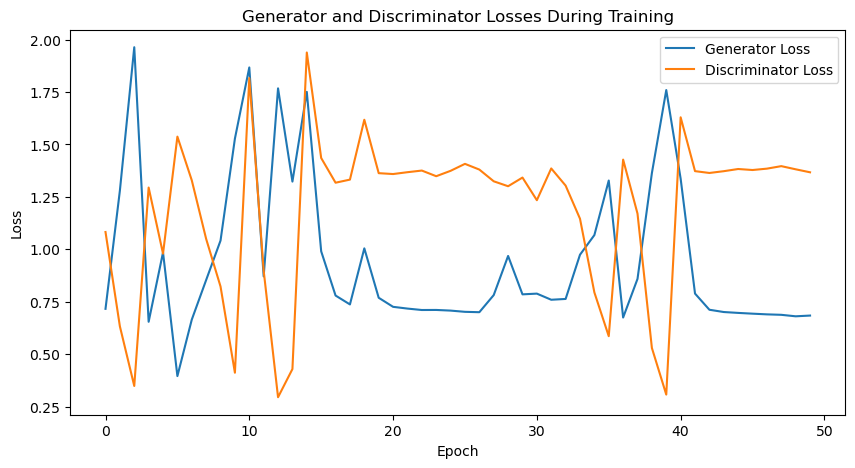

Testing with gamma value: 0.05


Calculating anomaly scores: 100%|████████████████████████████████████████████████| 2471/2471 [1:21:07<00:00,  1.97s/it]


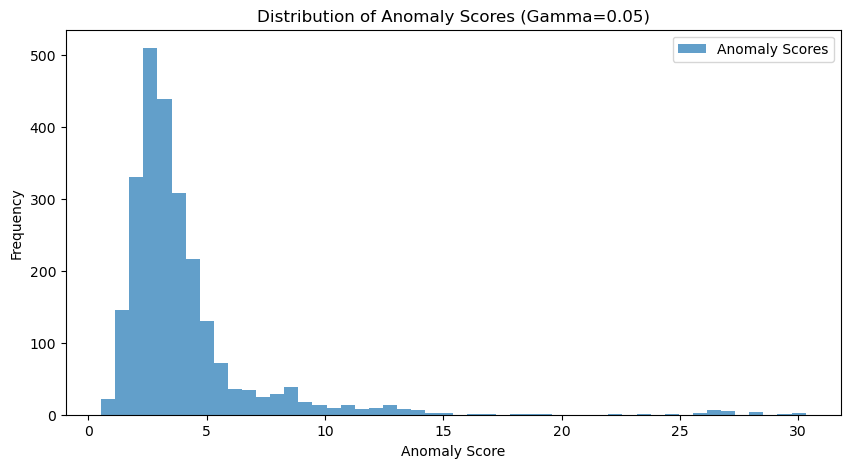

Anomaly detection threshold (Gamma=0.05): 13.832501320439894
Detected anomalies with gamma 0.05: 39 out of 2471 sequences


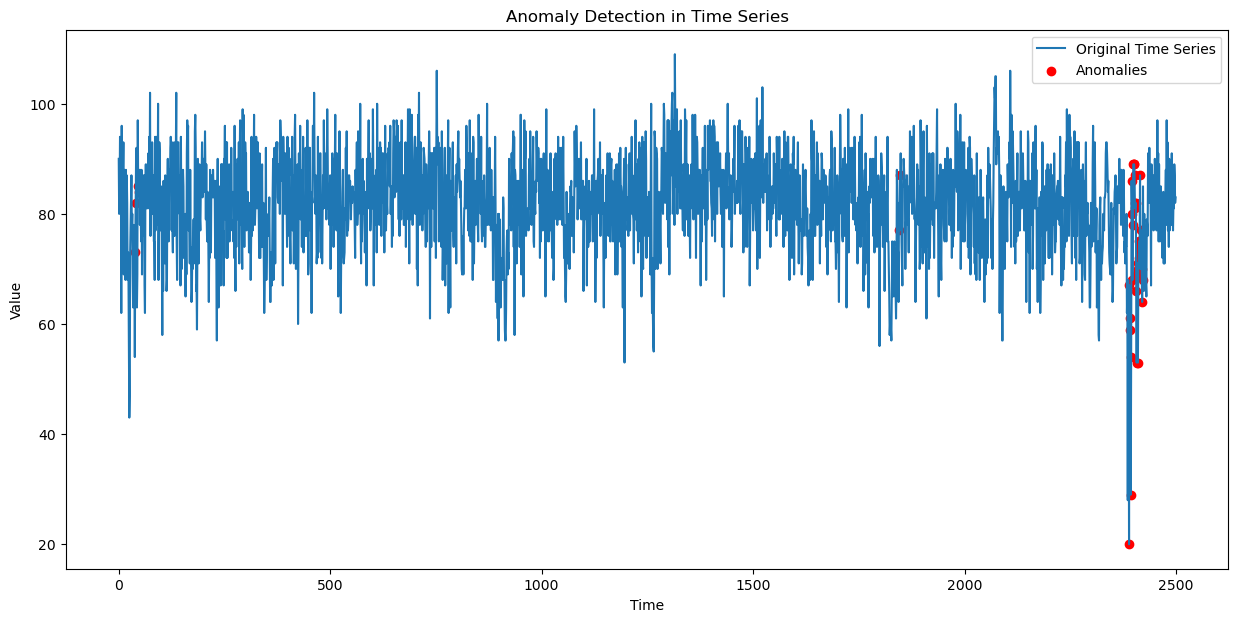

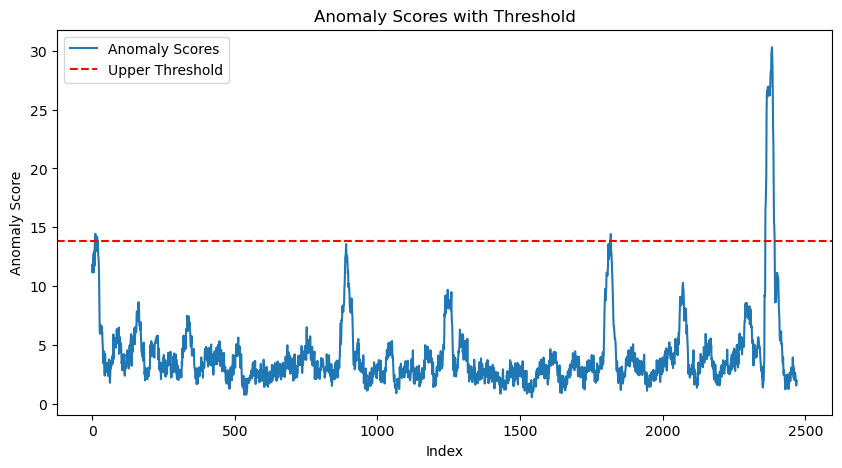

Testing with gamma value: 0.3


Calculating anomaly scores: 100%|██████████████████████████████████████████████████| 2471/2471 [37:37<00:00,  1.09it/s]


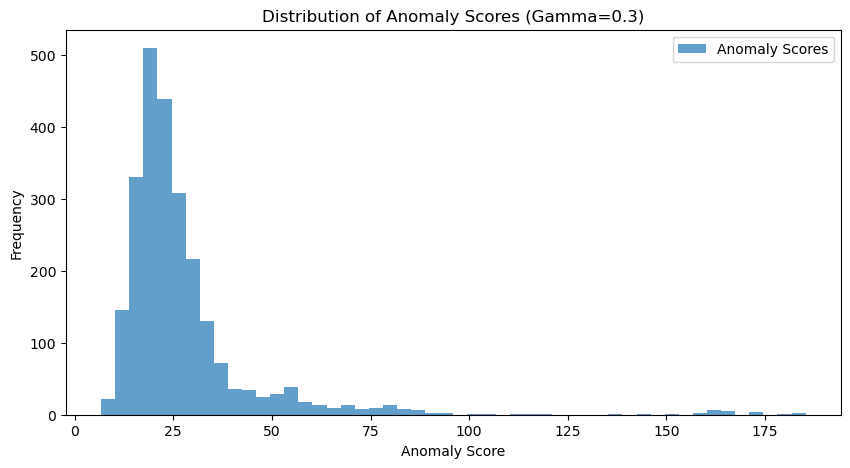

Anomaly detection threshold (Gamma=0.3): 86.41446372924445
Detected anomalies with gamma 0.3: 39 out of 2471 sequences


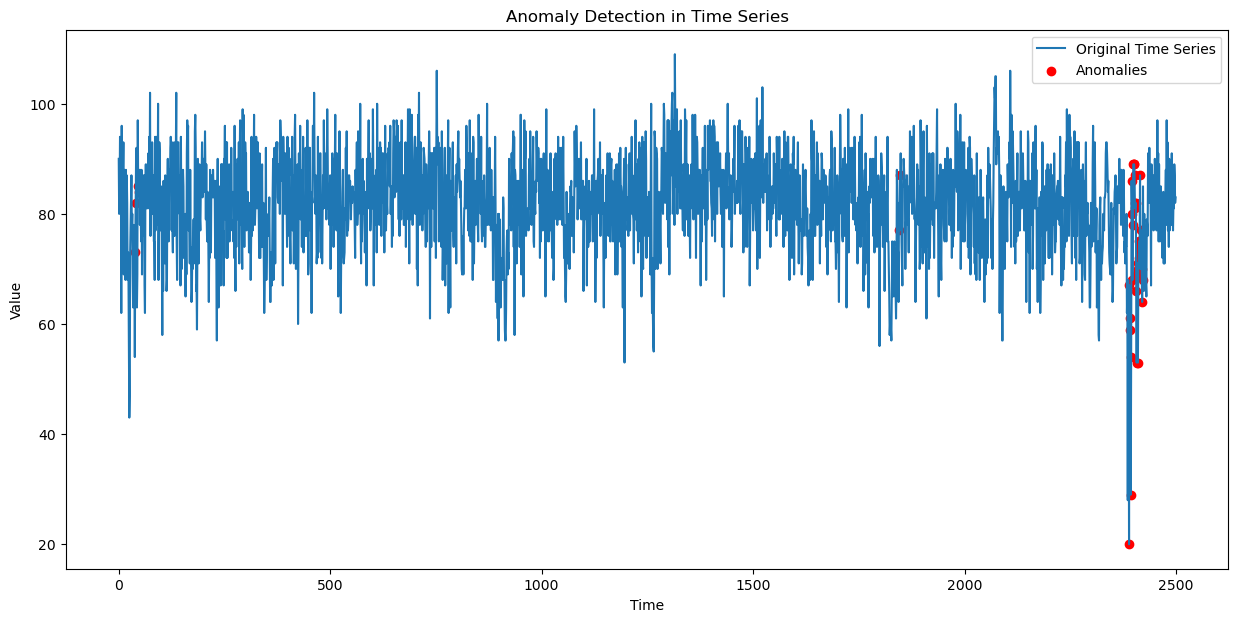

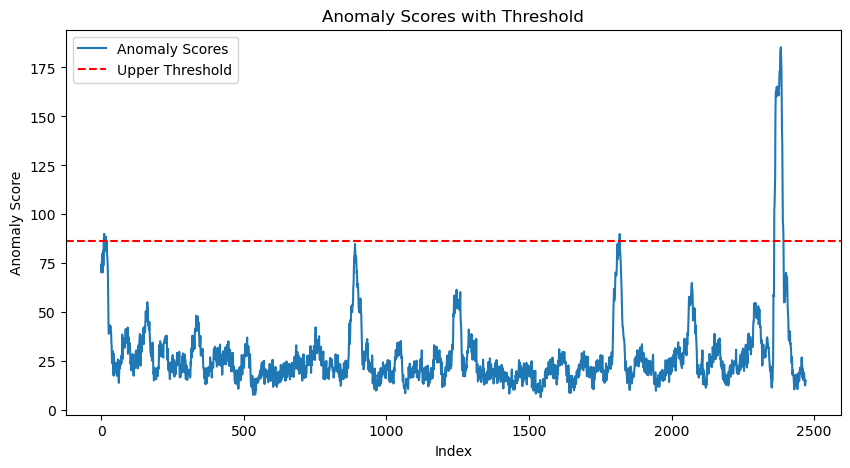

Testing with gamma value: 0.7


Calculating anomaly scores: 100%|██████████████████████████████████████████████████| 2471/2471 [41:13<00:00,  1.00s/it]


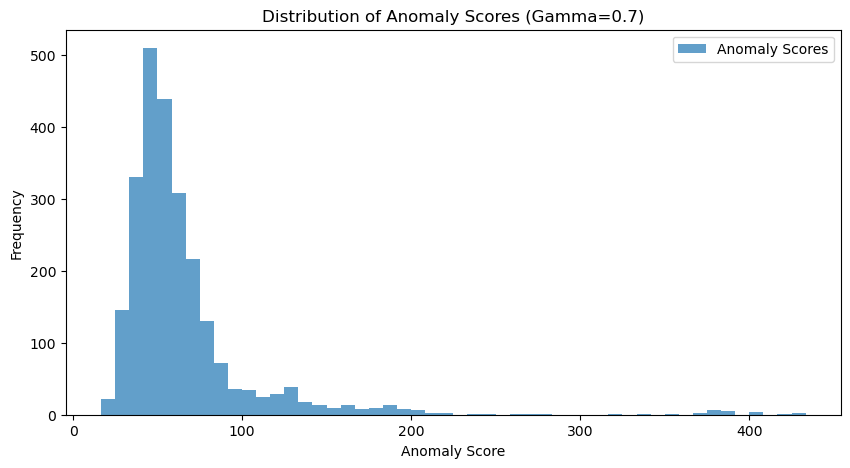

Anomaly detection threshold (Gamma=0.7): 202.5456273158403
Detected anomalies with gamma 0.7: 39 out of 2471 sequences


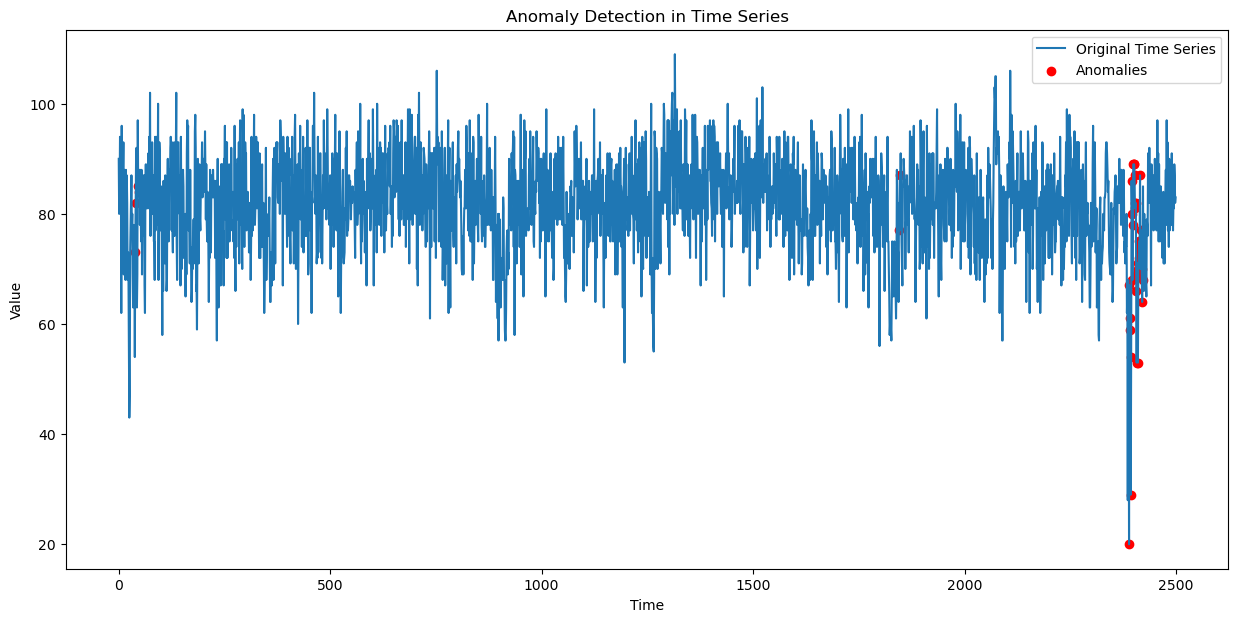

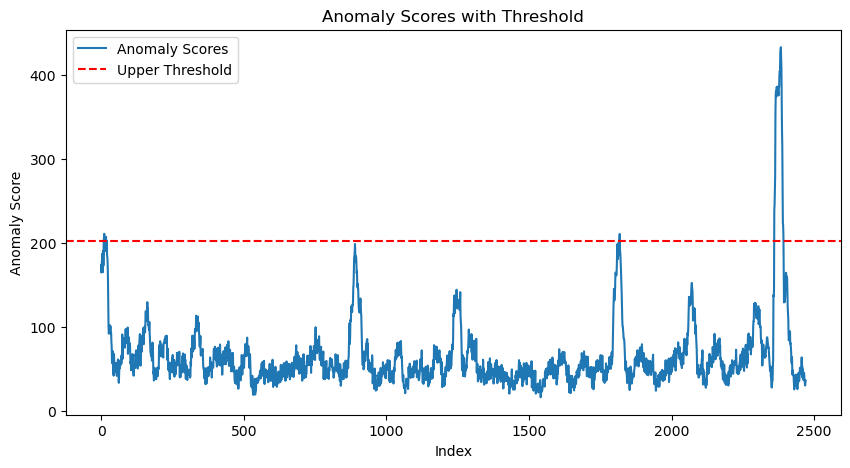

Total training and detection time: 14889.91 seconds


In [1]:
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('./realTraffic/realTraffic/speed_6005.csv')
time_series = df['value'].values

# Sliding window approach
window_size = 30

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size + 1):
        seq = data[i:i + window_size]
        sequences.append(seq)
    return np.array(sequences)

# Measure the time taken to create sequences
start_time = time.time()
sequences = create_sequences(time_series, window_size)
sequences = torch.tensor(sequences, dtype=torch.float32)
print(f"Time taken to create sequences: {time.time() - start_time:.2f} seconds")

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, 1)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.fc(x)
        return x

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=100, num_layers=1, batch_first=True)
        self.fc = nn.Linear(100, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Using the output from the last time step
        return torch.sigmoid(x)

# Adversarial training function
def adversarial_train(X, epochs=50, batch_size=32, lr_g=0.0003, lr_d=0.0001):
    G = Generator()
    D = Discriminator()
    
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=lr_g)
    optimizer_D = optim.Adam(D.parameters(), lr=lr_d)
    
    dataset = TensorDataset(X, X)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    G_losses = []
    D_losses = []
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        
        for real_data, _ in dataloader:
            batch_start_time = time.time()
            batch_size = real_data.size(0)
            
            # Train Discriminator
            noise = torch.randn(batch_size, window_size, 1)
            fake_data = G(noise)
            
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)
            
            # Add noise to the discriminator's inputs
            real_data_noisy = real_data + 0.05 * torch.randn_like(real_data)
            fake_data_noisy = fake_data + 0.05 * torch.randn_like(fake_data)
            
            D_real = D(real_data_noisy.unsqueeze(-1))
            D_fake = D(fake_data_noisy)
            
            loss_real = criterion(D_real, real_labels)
            loss_fake = criterion(D_fake, fake_labels)
            loss_D = loss_real + loss_fake
            
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()
            
            # Train Generator more frequently
            for _ in range(4):
                noise = torch.randn(batch_size, window_size, 1)
                fake_data = G(noise)
                D_fake = D(fake_data)
                
                loss_G = criterion(D_fake, real_labels)
                
                optimizer_G.zero_grad()
                loss_G.backward()
                optimizer_G.step()
            
            print(f"Batch time: {time.time() - batch_start_time:.2f} seconds")
        
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        
        # Print progress update every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f} | Epoch time: {time.time() - epoch_start_time:.2f} seconds')
    
    return G, D, G_losses, D_losses

# Anomaly scoring function with progress bar
def anomaly_score(X, G, D, gamma, iterations=40, lr=0.001):
    anomaly_scores = []
    criterion = nn.MSELoss()
    
    for xi in tqdm(X, desc="Calculating anomaly scores"):
        xi = xi.unsqueeze(0).unsqueeze(-1)  # Add batch and feature dimensions
        zi = torch.randn(1, window_size, 1, requires_grad=True)  # Initialize noise vector
        optimizer = optim.Adam([zi], lr=lr)
        
        for _ in range(iterations):
            fake_data = G(zi)  # Generate fake sequence from noise
            loss_reconstruction = criterion(fake_data, xi)  # Calculate reconstruction error (MSE)
            
            # Discriminator's output for the fake sequence
            D_fake = D(fake_data)
            loss_discriminator = torch.mean(torch.log(D_fake + 1e-6))  # Avoid log(0) by adding a small value
            
            # Total loss: gamma * reconstruction loss + (1 - gamma) * discriminator loss
            loss = gamma * loss_reconstruction + (1 - gamma) * loss_discriminator
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Calculate final anomaly score
        final_loss = gamma * loss_reconstruction.item() + (1 - gamma) * loss_discriminator.item()
        anomaly_scores.append(final_loss)
    
    return anomaly_scores

# Determine anomalies based on mean and standard deviation for each window
def detect_anomalies(anomaly_scores, std_dev_factor=3):
    mean_score = np.mean(anomaly_scores)
    std_dev = np.std(anomaly_scores)
    upper_threshold = mean_score + std_dev_factor * std_dev
    
    anomalies = [score > upper_threshold for score in anomaly_scores]
    return anomalies, upper_threshold

# Plotting functions
def plot_time_series_with_anomalies(time_series, anomalies, window_size):
    plt.figure(figsize=(15, 7))
    plt.plot(time_series, label='Original Time Series')
    anomaly_indices = [i + window_size - 1 for i, is_anomaly in enumerate(anomalies) if is_anomaly]
    plt.scatter(anomaly_indices, time_series[anomaly_indices], color='red', label='Anomalies')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Anomaly Detection in Time Series')
    plt.show()

def plot_anomaly_scores_with_threshold(anomaly_scores, upper_threshold):
    plt.figure(figsize=(10, 5))
    plt.plot(anomaly_scores, label='Anomaly Scores')
    plt.axhline(y=upper_threshold, color='r', linestyle='--', label='Upper Threshold')
    plt.xlabel('Index')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.title('Anomaly Scores with Threshold')
    plt.show()

# Main function to run the training and detection process for different gamma values
def main():
    G, D, G_losses, D_losses = adversarial_train(sequences)
    
    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label='Generator Loss')
    plt.plot(D_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Losses During Training')
    plt.show()
    
    gamma_values = [0.05, 0.3, 0.7]
    for gamma in gamma_values:
        print(f"Testing with gamma value: {gamma}")
        anomaly_scores = anomaly_score(sequences, G, D, gamma)
        
        # Analyze anomaly scores distribution
        plt.figure(figsize=(10, 5))
        plt.hist(anomaly_scores, bins=50, alpha=0.7, label='Anomaly Scores')
        plt.xlabel('Anomaly Score')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Anomaly Scores (Gamma={gamma})')
        plt.legend()
        plt.show()
        
        # Set a threshold for detecting anomalies using mean and std deviation for each window
        std_dev_factor = 3  # Example factor, you can experiment with different values
        anomalies, upper_threshold = detect_anomalies(anomaly_scores, std_dev_factor)
        print(f"Anomaly detection threshold (Gamma={gamma}): {upper_threshold}")
        
        print(f"Detected anomalies with gamma {gamma}: {sum(anomalies)} out of {len(anomalies)} sequences")
        
        # Plot anomalies
        plot_time_series_with_anomalies(time_series, anomalies, window_size)
        plot_anomaly_scores_with_threshold(anomaly_scores, upper_threshold)

# Run the main function
start_time = time.time()
main()
print(f"Total training and detection time: {time.time() - start_time:.2f} seconds")